In [1]:
import sys
IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:
  %pip install --quiet git+https://github.com/raulonlab/crypto-band-indicators#egg=crypto_band_indicators

import backtrader as bt
from crypto_band_indicators.backtrader import RebalanceStrategy, WeightedDCAStrategy, DCAStrategy, HodlStrategy
from crypto_band_indicators.datas import TickerDataSource, FngDataSource
from crypto_band_indicators.indicators import FngBandIndicator, RainbowBandIndicator
from crypto_band_indicators import config
from tabulate import tabulate
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 200

# Global variables and ininitialisations
ticker_data_source = TickerDataSource().load()
FngDataSource().load()  # Preload cache
config.set(config.ONLY_CACHE, True)  # Use only data cached (and don't fetch data on every test)
config.set(config.ENABLE_BACKTRADER_LOG, False)  # Disable backtrader log output

# Compare strategies

Run a simulation of all the indicators / strategies for a given set of parameters and dates

Strategies:
- **Rebalance**: Applies a rebalance of the position of BTC over the total depending on the current indicator band.
- **Weighted DCA**: Variation of the traditional Dollar Cost Average (DCA) where the periodic order size changes depending on the current indicator band.
- **Hold**: Dummy buy and hold
- **Standard DCA**: Dummy DCA strategy 

Indicators:
- **Fear and Greed**
- **Rainbow**


### Parameters and dates

In [2]:
# Common parameters
initial_cash        = 10000.0       # initial broker cash. Default 10000 usd
min_order_period    = 5             # Minimum period in days to place orders
base_buy_amount     = 100           # Amount purchased in standard DCA

# Specific for Fear and greed indicator
fng_weighted_multipliers    = [1.5, 1.25, 1, 0.75, 0.5]  # buy amount multipliers (weighted) for each band
fng_rebalance_percents      = [85, 65, 50, 15, 10]       # rebalance percentage of BTC over total for each band
# Apply MA algorithm to smoth the indicator variations. See https://github.com/twopirllc/pandas-ta
fng_indicator_ta_config        = {'kind': 'wma', 'length': 3}
# Don't apply MA algorithm
# fng_indicator_ta_config        = None

# Specific for Rainbow indicator
rainbow_weighted_multipliers    = [0, 0.1, 0.2, 0.3, 0.5, 0.8, 1.3, 2.1, 3.4]
rainbow_rebalance_percents      = [10, 20, 30, 40, 50, 60, 70, 80, 90]
# Don't apply MA algorithm
rainbow_indicator_ta_config        = None

# Dates
start               = '01/01/2020'  # start date of the simulation. Ex: '01/01/2020' or None
end                 = '31/12/2020'  # end date of the simulation. Ex: '31/12/2020' or None


### Run simulation

In [3]:
def run(strategy_class, **kwargs):
    cerebro = bt.Cerebro(stdstats=False, runonce=True)
    cerebro.broker.set_coc(True)

    # Add strategy
    cerebro.addstrategy(strategy_class, **kwargs)

    # Add data feeds
    cerebro.adddata(ticker_data_source.to_backtrade_feed(start, end))

    # Set broker initial cash
    cerebro.broker.setcash(initial_cash)

    # Run simulation!
    cerebro_results = cerebro.run()
    print(f"✔ Done {strategy_class.__name__}")

    return cerebro_results[0]


all_run_results = list()

# Weighted Av strategy with Fear and Greed indicator
run_result = run(
    strategy_class=WeightedDCAStrategy,
    indicator_class=FngBandIndicator,
    indicator_ta_config=fng_indicator_ta_config,
    base_buy_amount=base_buy_amount,
    min_order_period=min_order_period,
    weighted_multipliers=fng_weighted_multipliers,
)
all_run_results.append(run_result)

# Rainbow Weighted Av strategy
run_result = run(
    strategy_class=WeightedDCAStrategy,
    indicator_class=RainbowBandIndicator,
    indicator_ta_config=rainbow_indicator_ta_config,
    base_buy_amount=base_buy_amount,
    min_order_period=min_order_period,
    weighted_multipliers=rainbow_weighted_multipliers,
)
all_run_results.append(run_result)

# Fear and Greed Rebalance strategy
run_result = run(
    strategy_class=RebalanceStrategy,
    indicator_class=FngBandIndicator,
    indicator_ta_config=fng_indicator_ta_config,
    min_order_period=min_order_period,
    rebalance_percents=fng_rebalance_percents,
)
all_run_results.append(run_result)

# Rainbow Rebalance strategy
run_result = run(
    strategy_class=RebalanceStrategy,
    indicator_class=RainbowBandIndicator,
    indicator_ta_config=rainbow_indicator_ta_config,
    min_order_period=min_order_period,
    rebalance_percents=rainbow_rebalance_percents,
)
all_run_results.append(run_result)

# Standard DCA
run_result = run(
    strategy_class=DCAStrategy,
    buy_amount=base_buy_amount,
    min_order_period=min_order_period,
)
all_run_results.append(run_result)

# HODL
run_result = run(
    strategy_class=HodlStrategy,
    percent=100,
)
all_run_results.append(run_result)

# Sort results by pnl_value
sorted_run_results = sorted(all_run_results, key=lambda strategy: float(strategy.pnl_value), reverse=True)

✔ Done WeightedDCAStrategy
✔ Done WeightedDCAStrategy
✔ Done RebalanceStrategy
✔ Done RebalanceStrategy
✔ Done DCAStrategy
✔ Done HodlStrategy


### Show results

In [4]:

column_keys = ['name', 'pnl_value', 'pnl_percent']
column_headers = ['Strategy', 'PNL USDT', 'PNL %']
sorted_run_details = map(lambda strategy: strategy.describe(keys=column_keys), sorted_run_results)
print(tabulate([details.values() for details in sorted_run_details], 
                tablefmt="github", 
                headers=column_headers, 
                floatfmt="+.2f"))

| Strategy                    |   PNL USDT |   PNL % |
|-----------------------------|------------|---------|
| HODL 100%                   |  +30255.78 | +302.56 |
| Weighted DCA Rainbow        |  +20810.25 | +208.10 |
| Rebalance Rainbow           |  +18916.03 | +189.16 |
| Weighted DCA Fear and Greed |  +15668.17 | +156.68 |
| DCA 100.00$                 |  +13905.02 | +139.05 |
| Rebalance Fear and Greed    |   +6375.92 |  +63.76 |


### Plot results

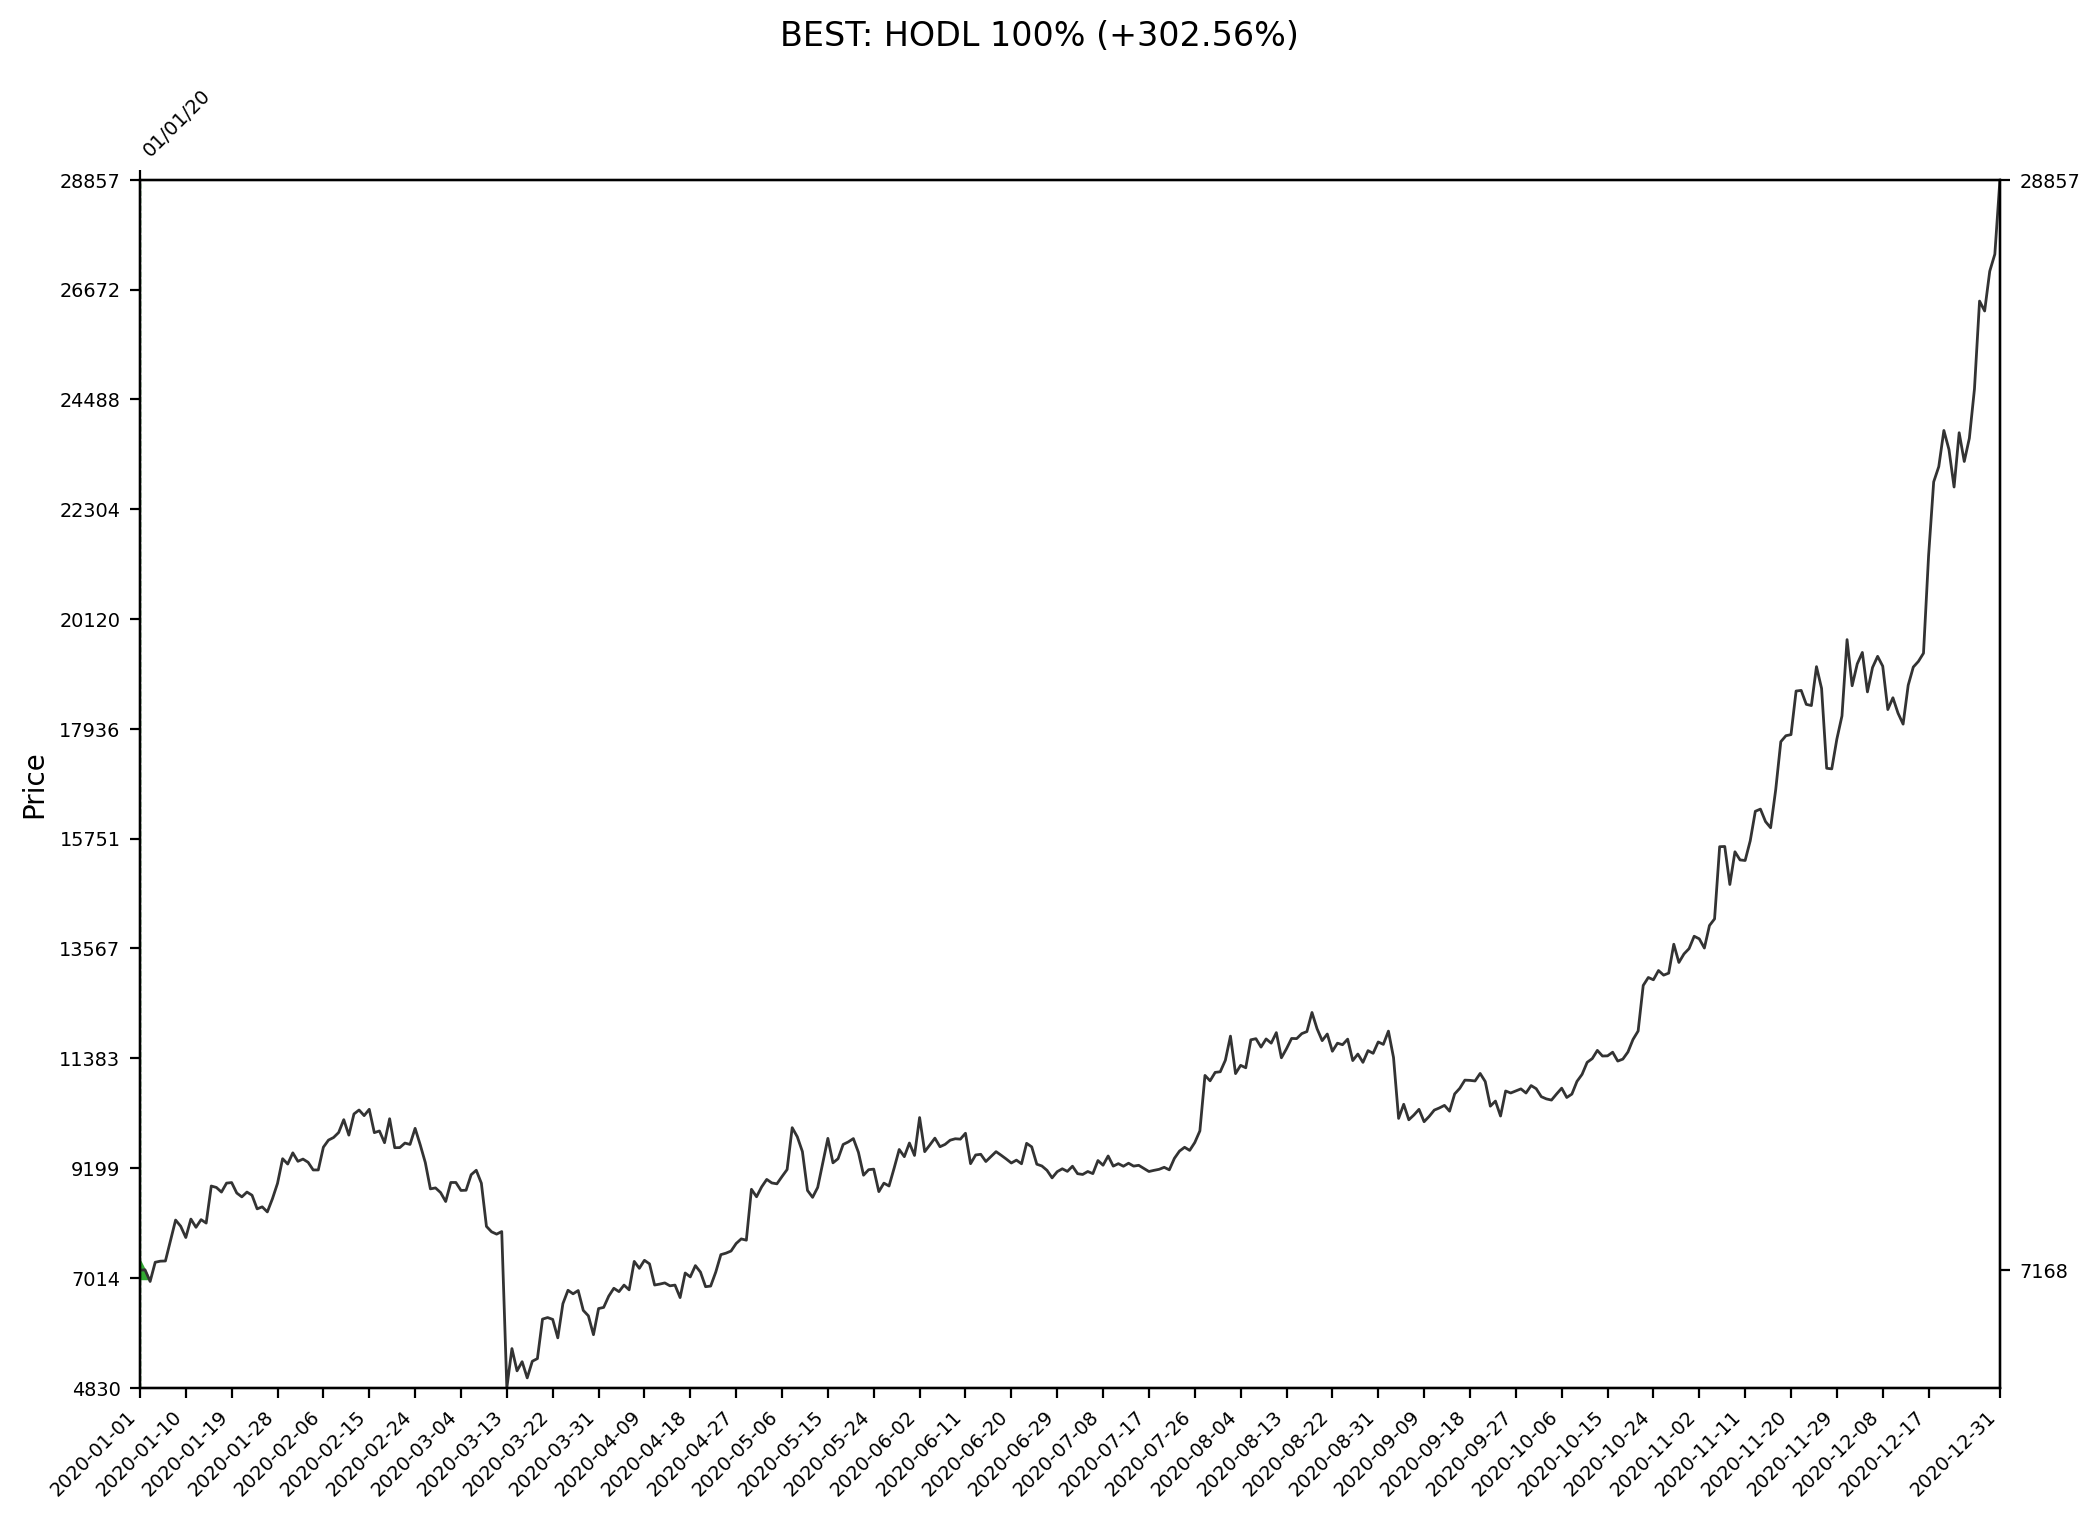

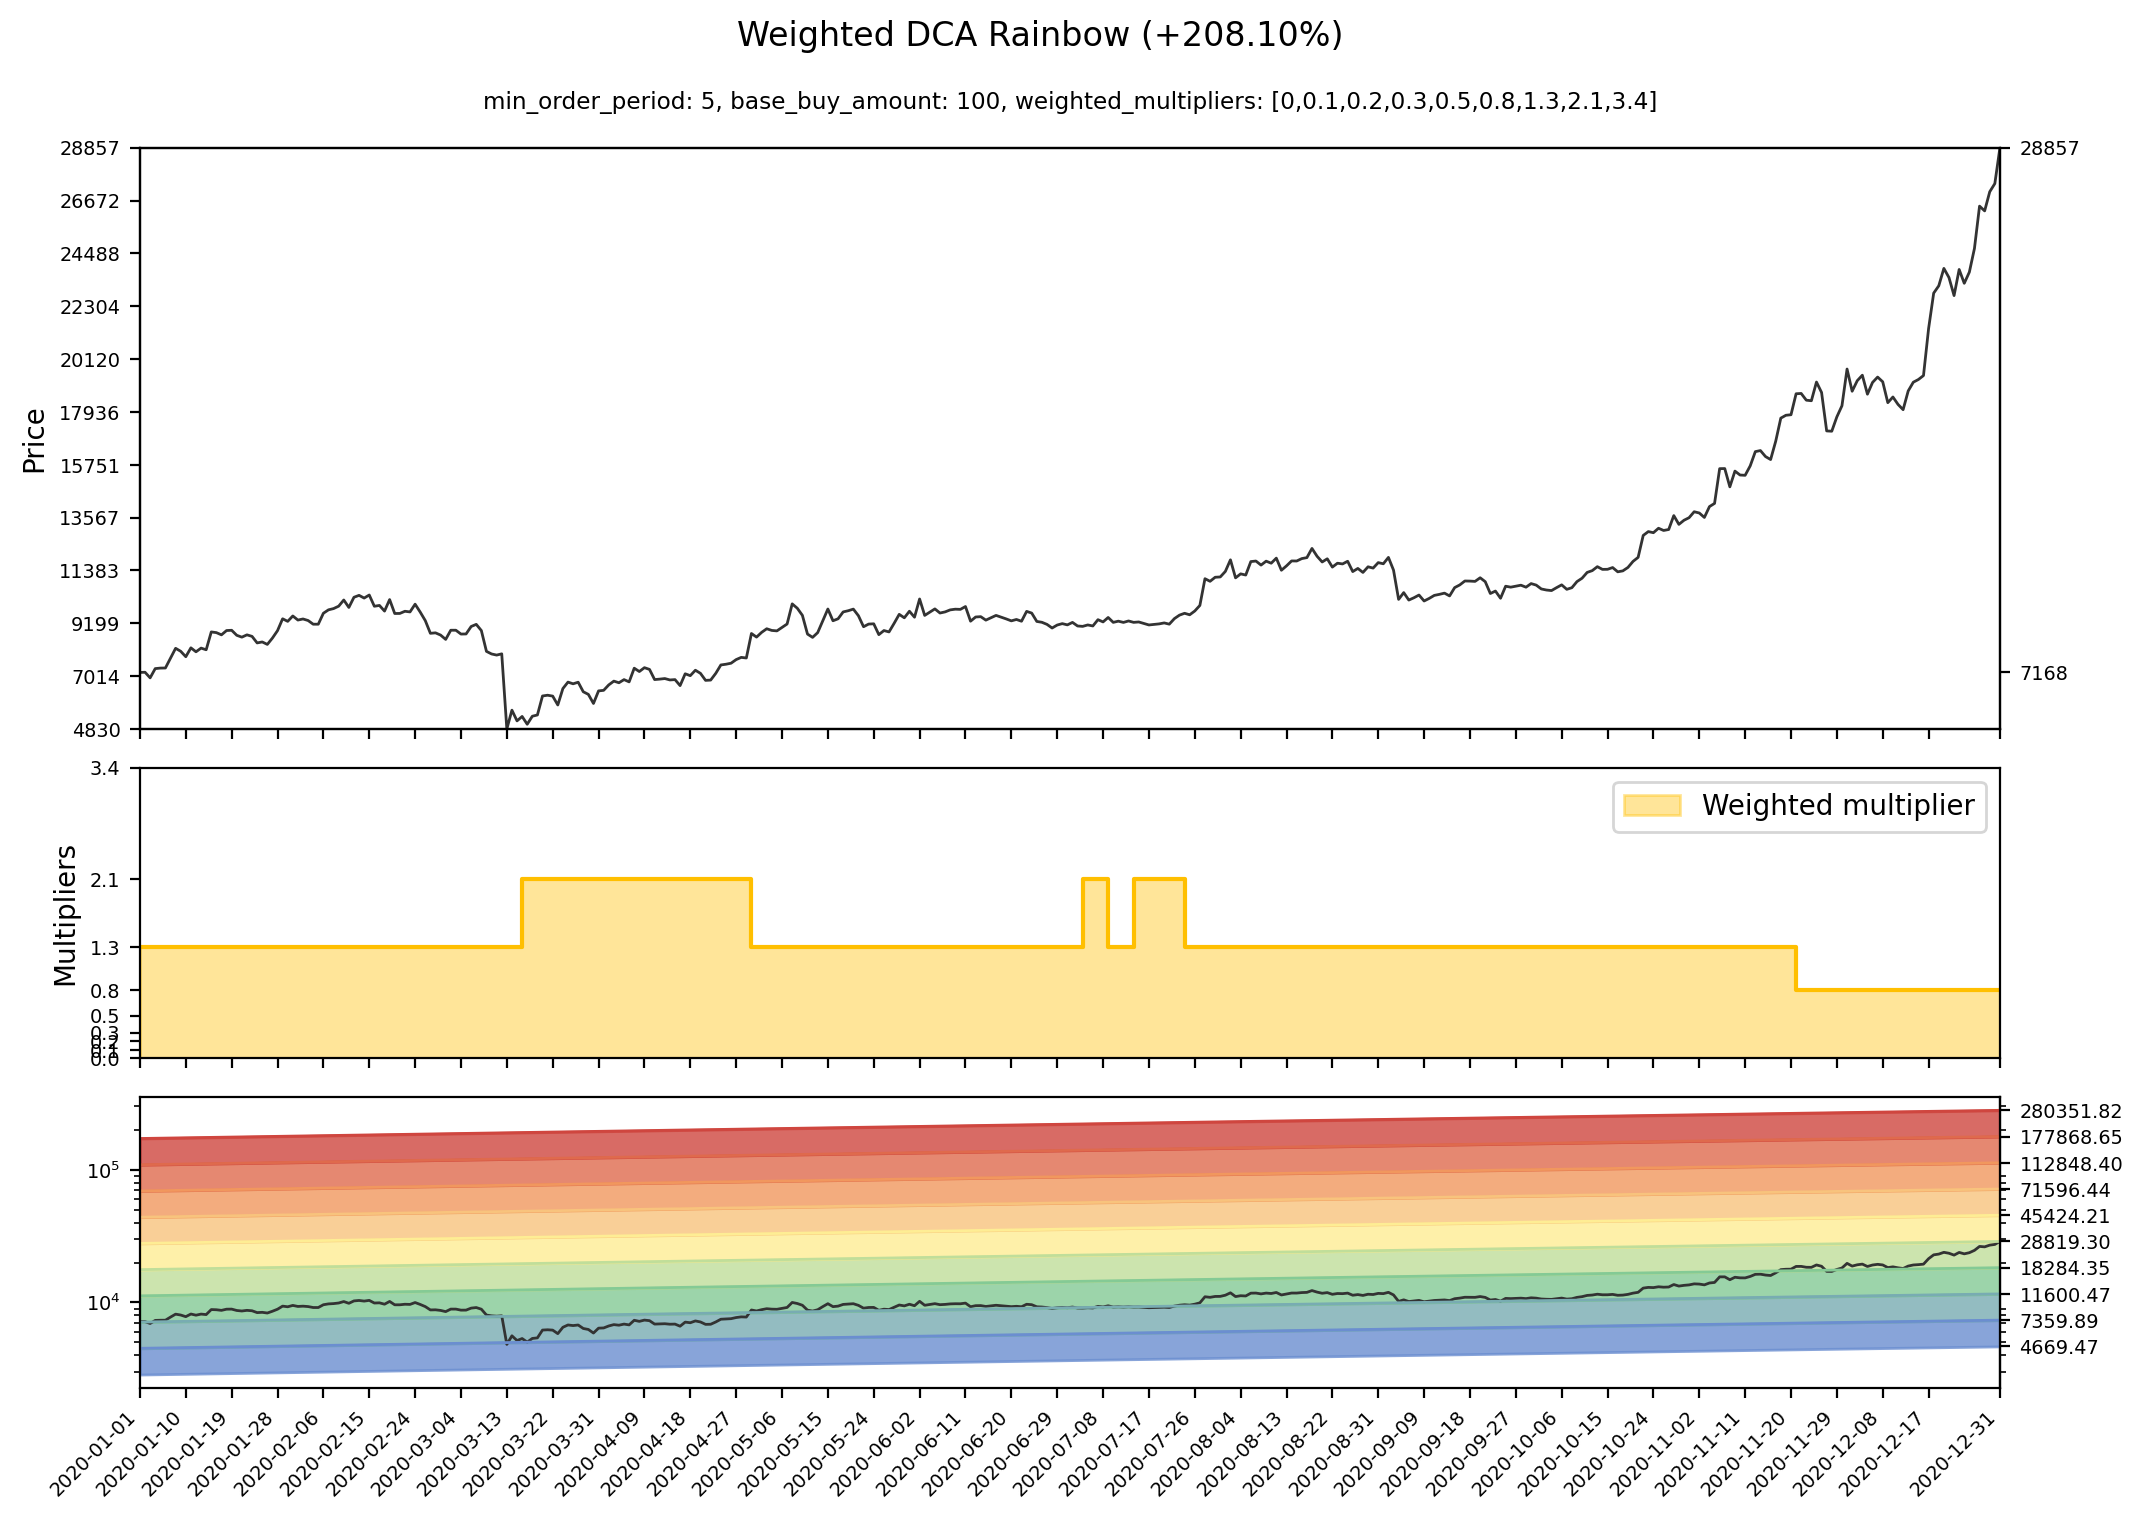

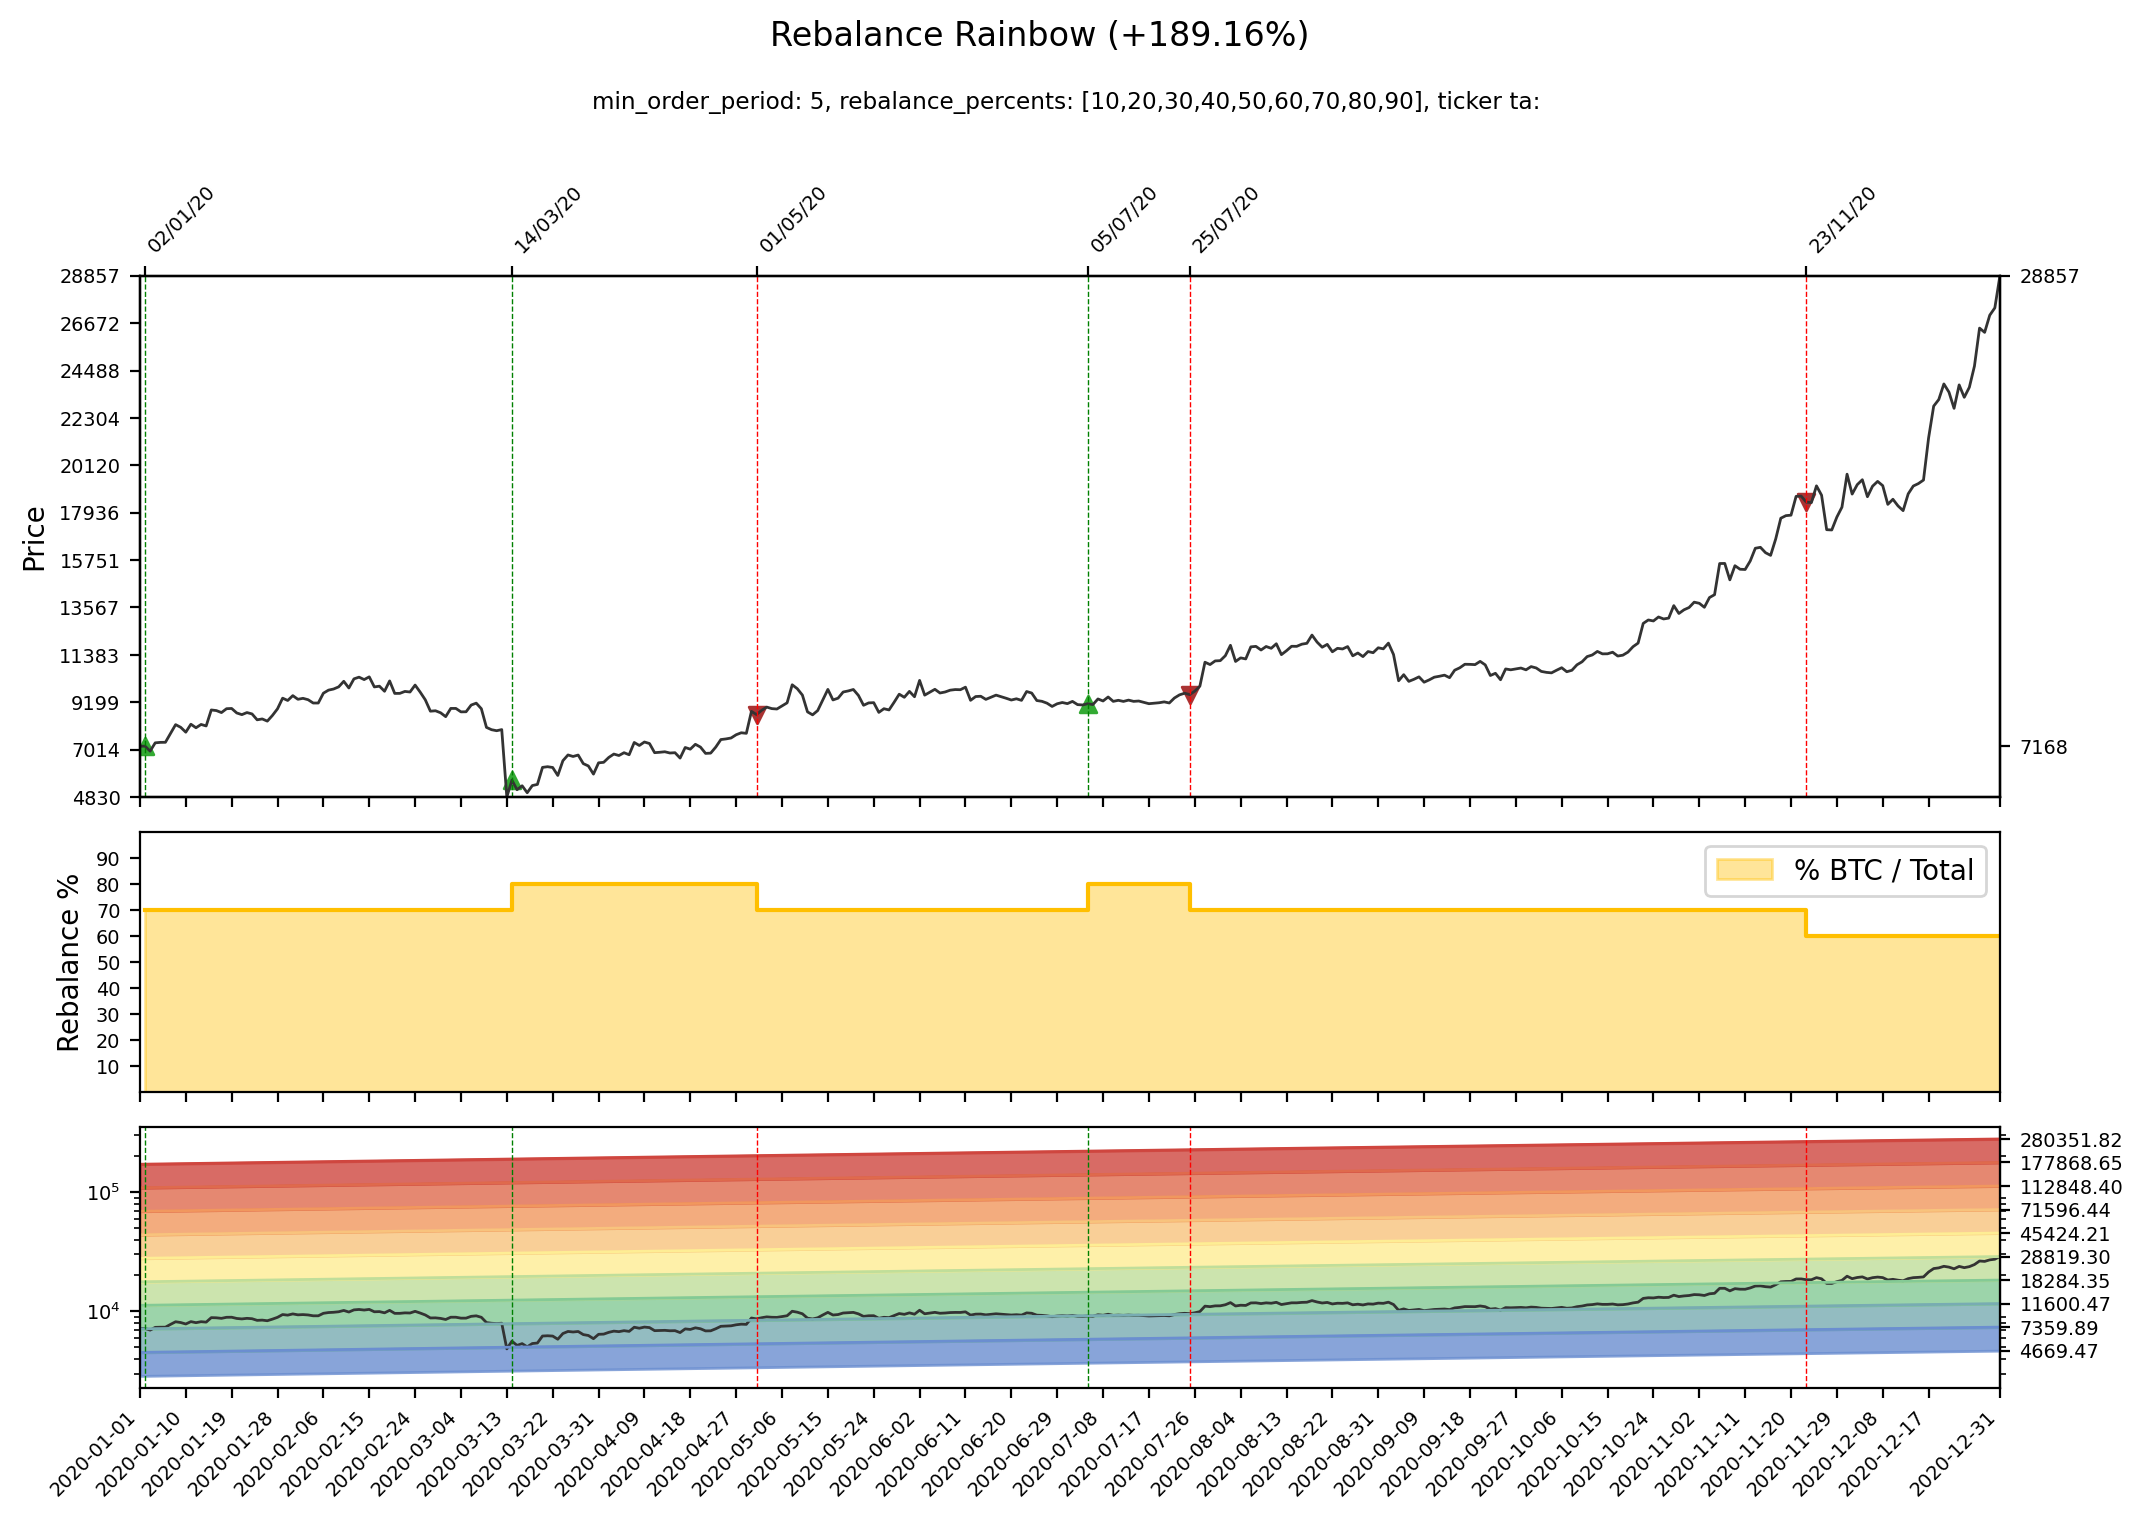

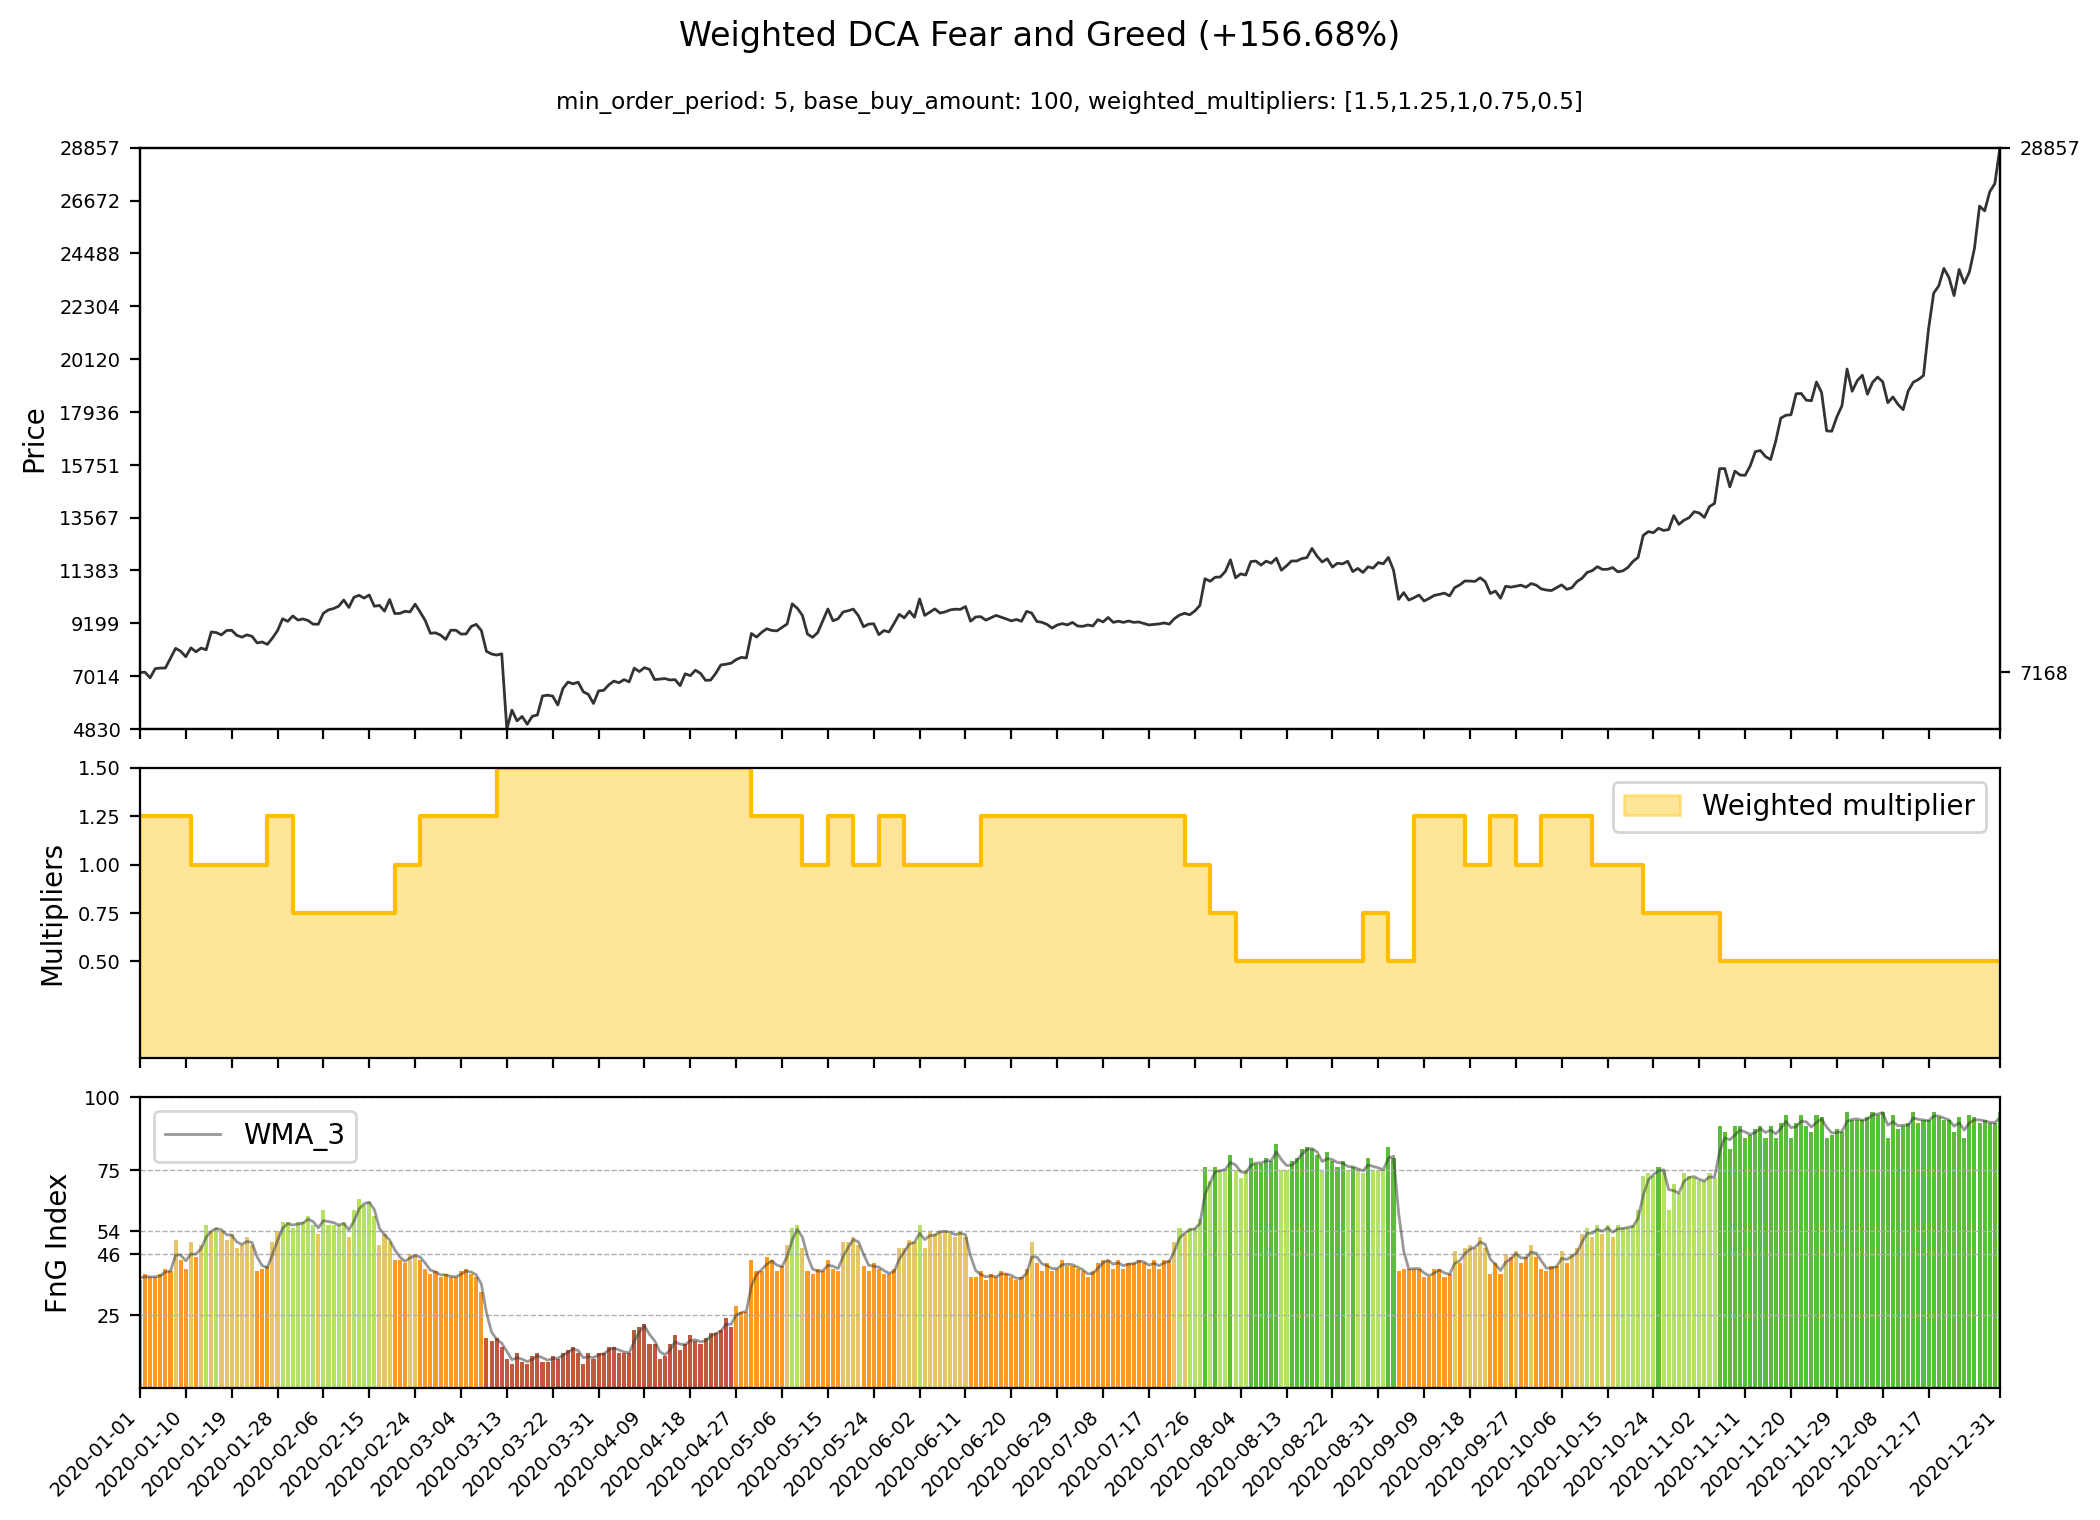

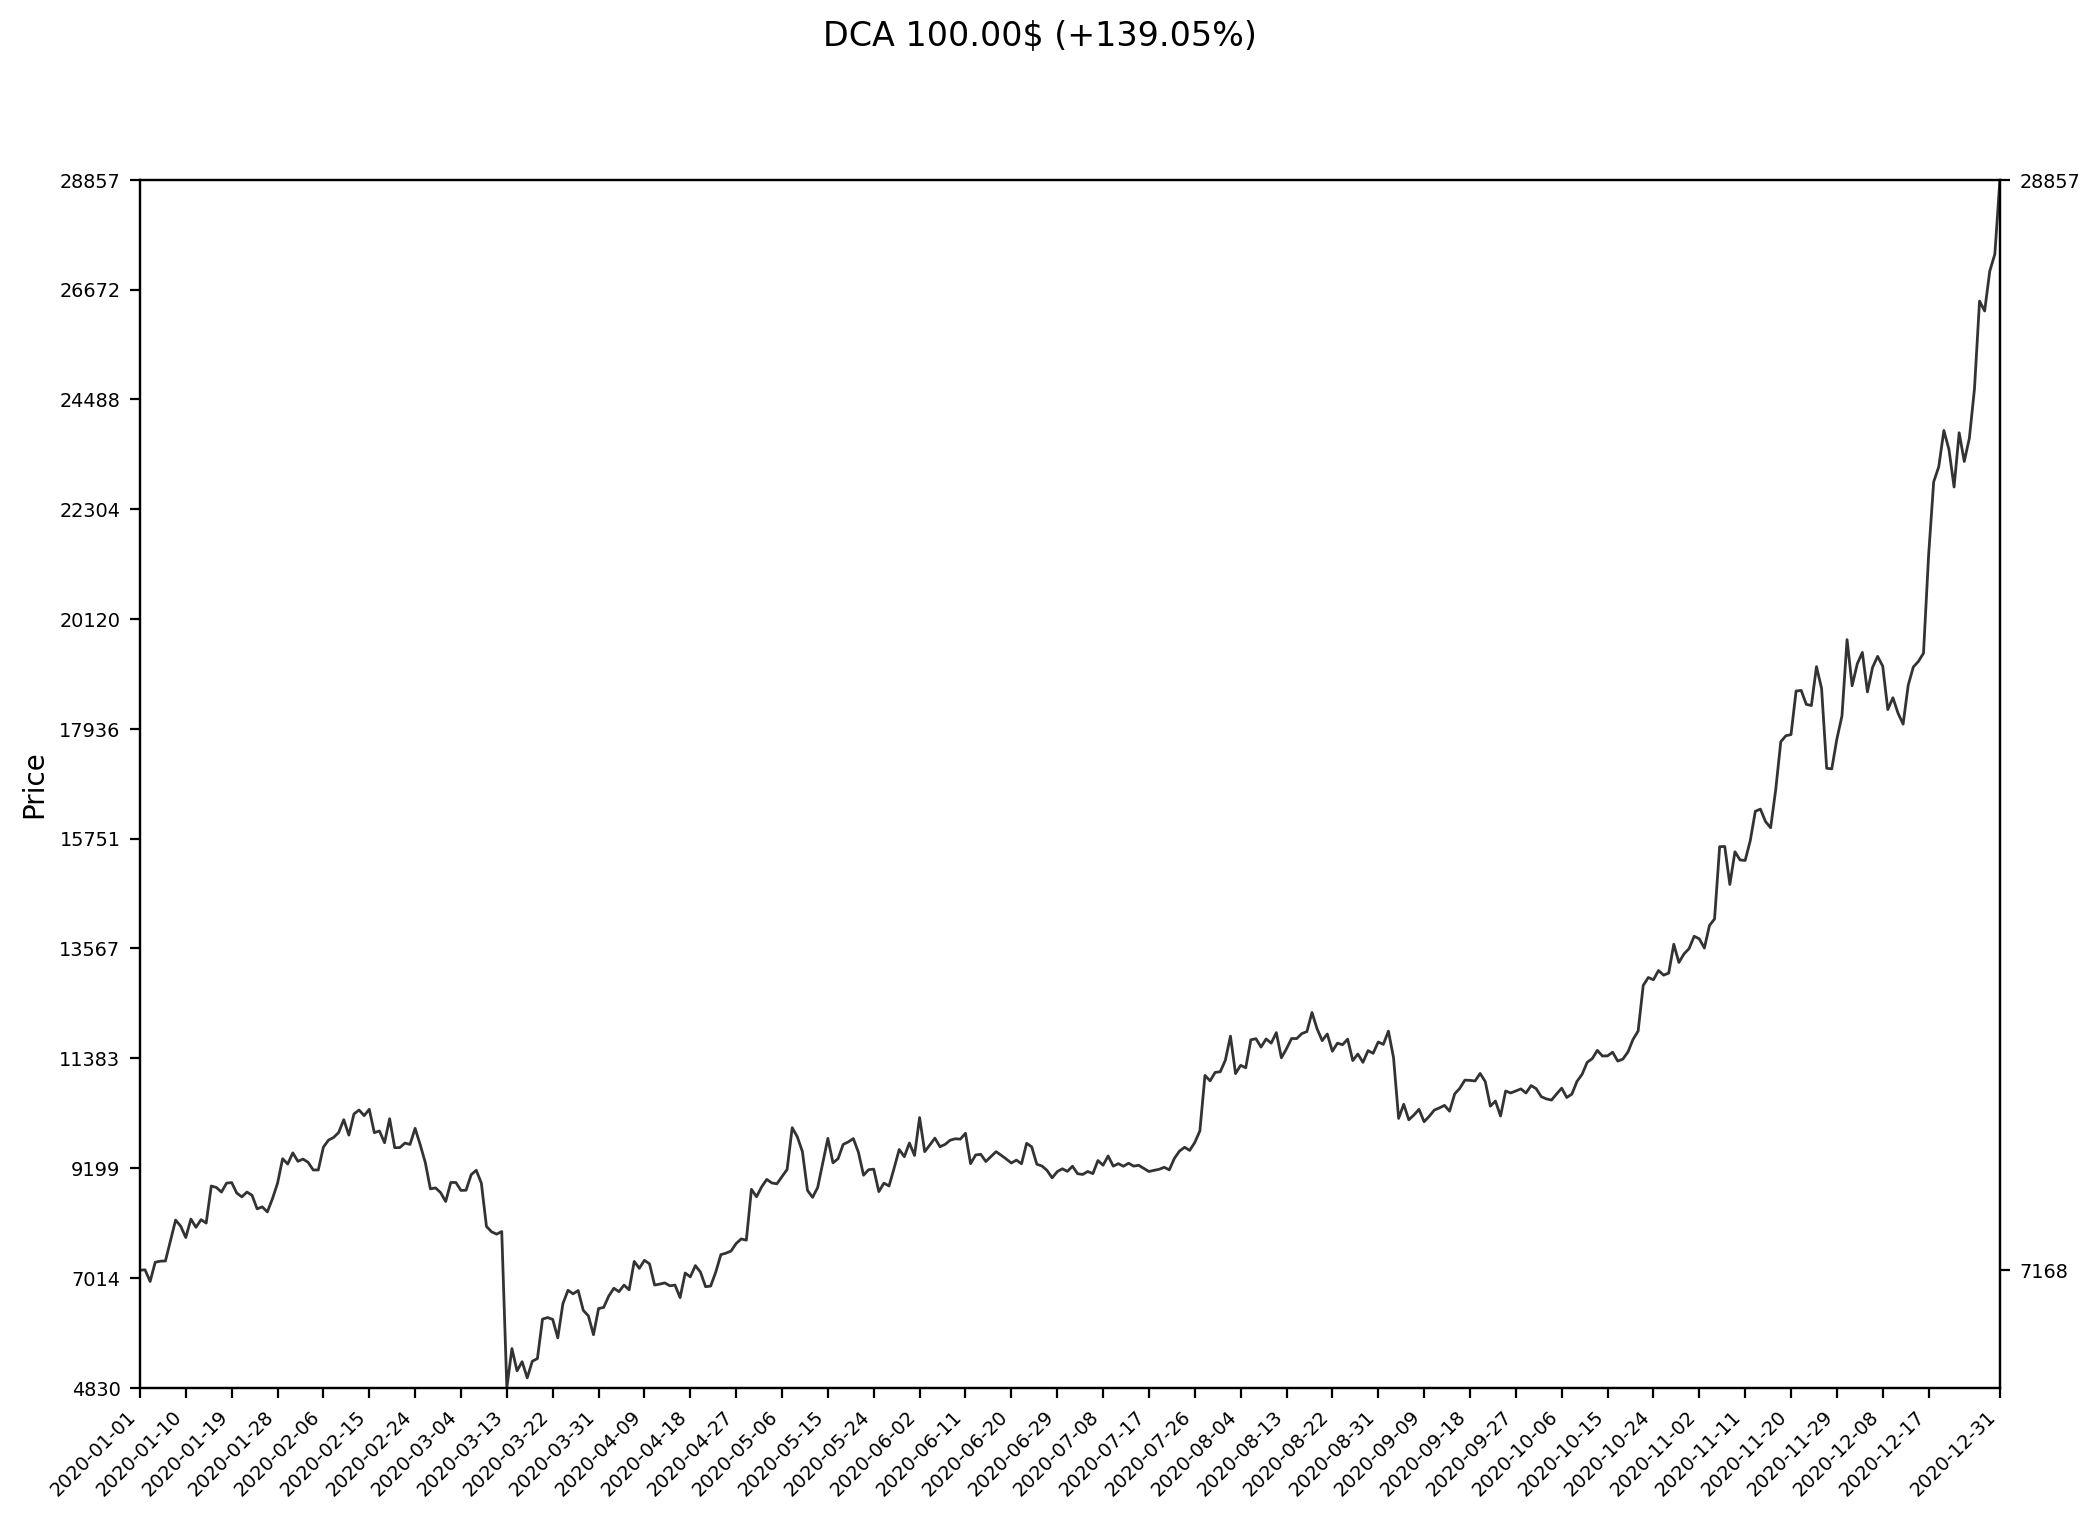

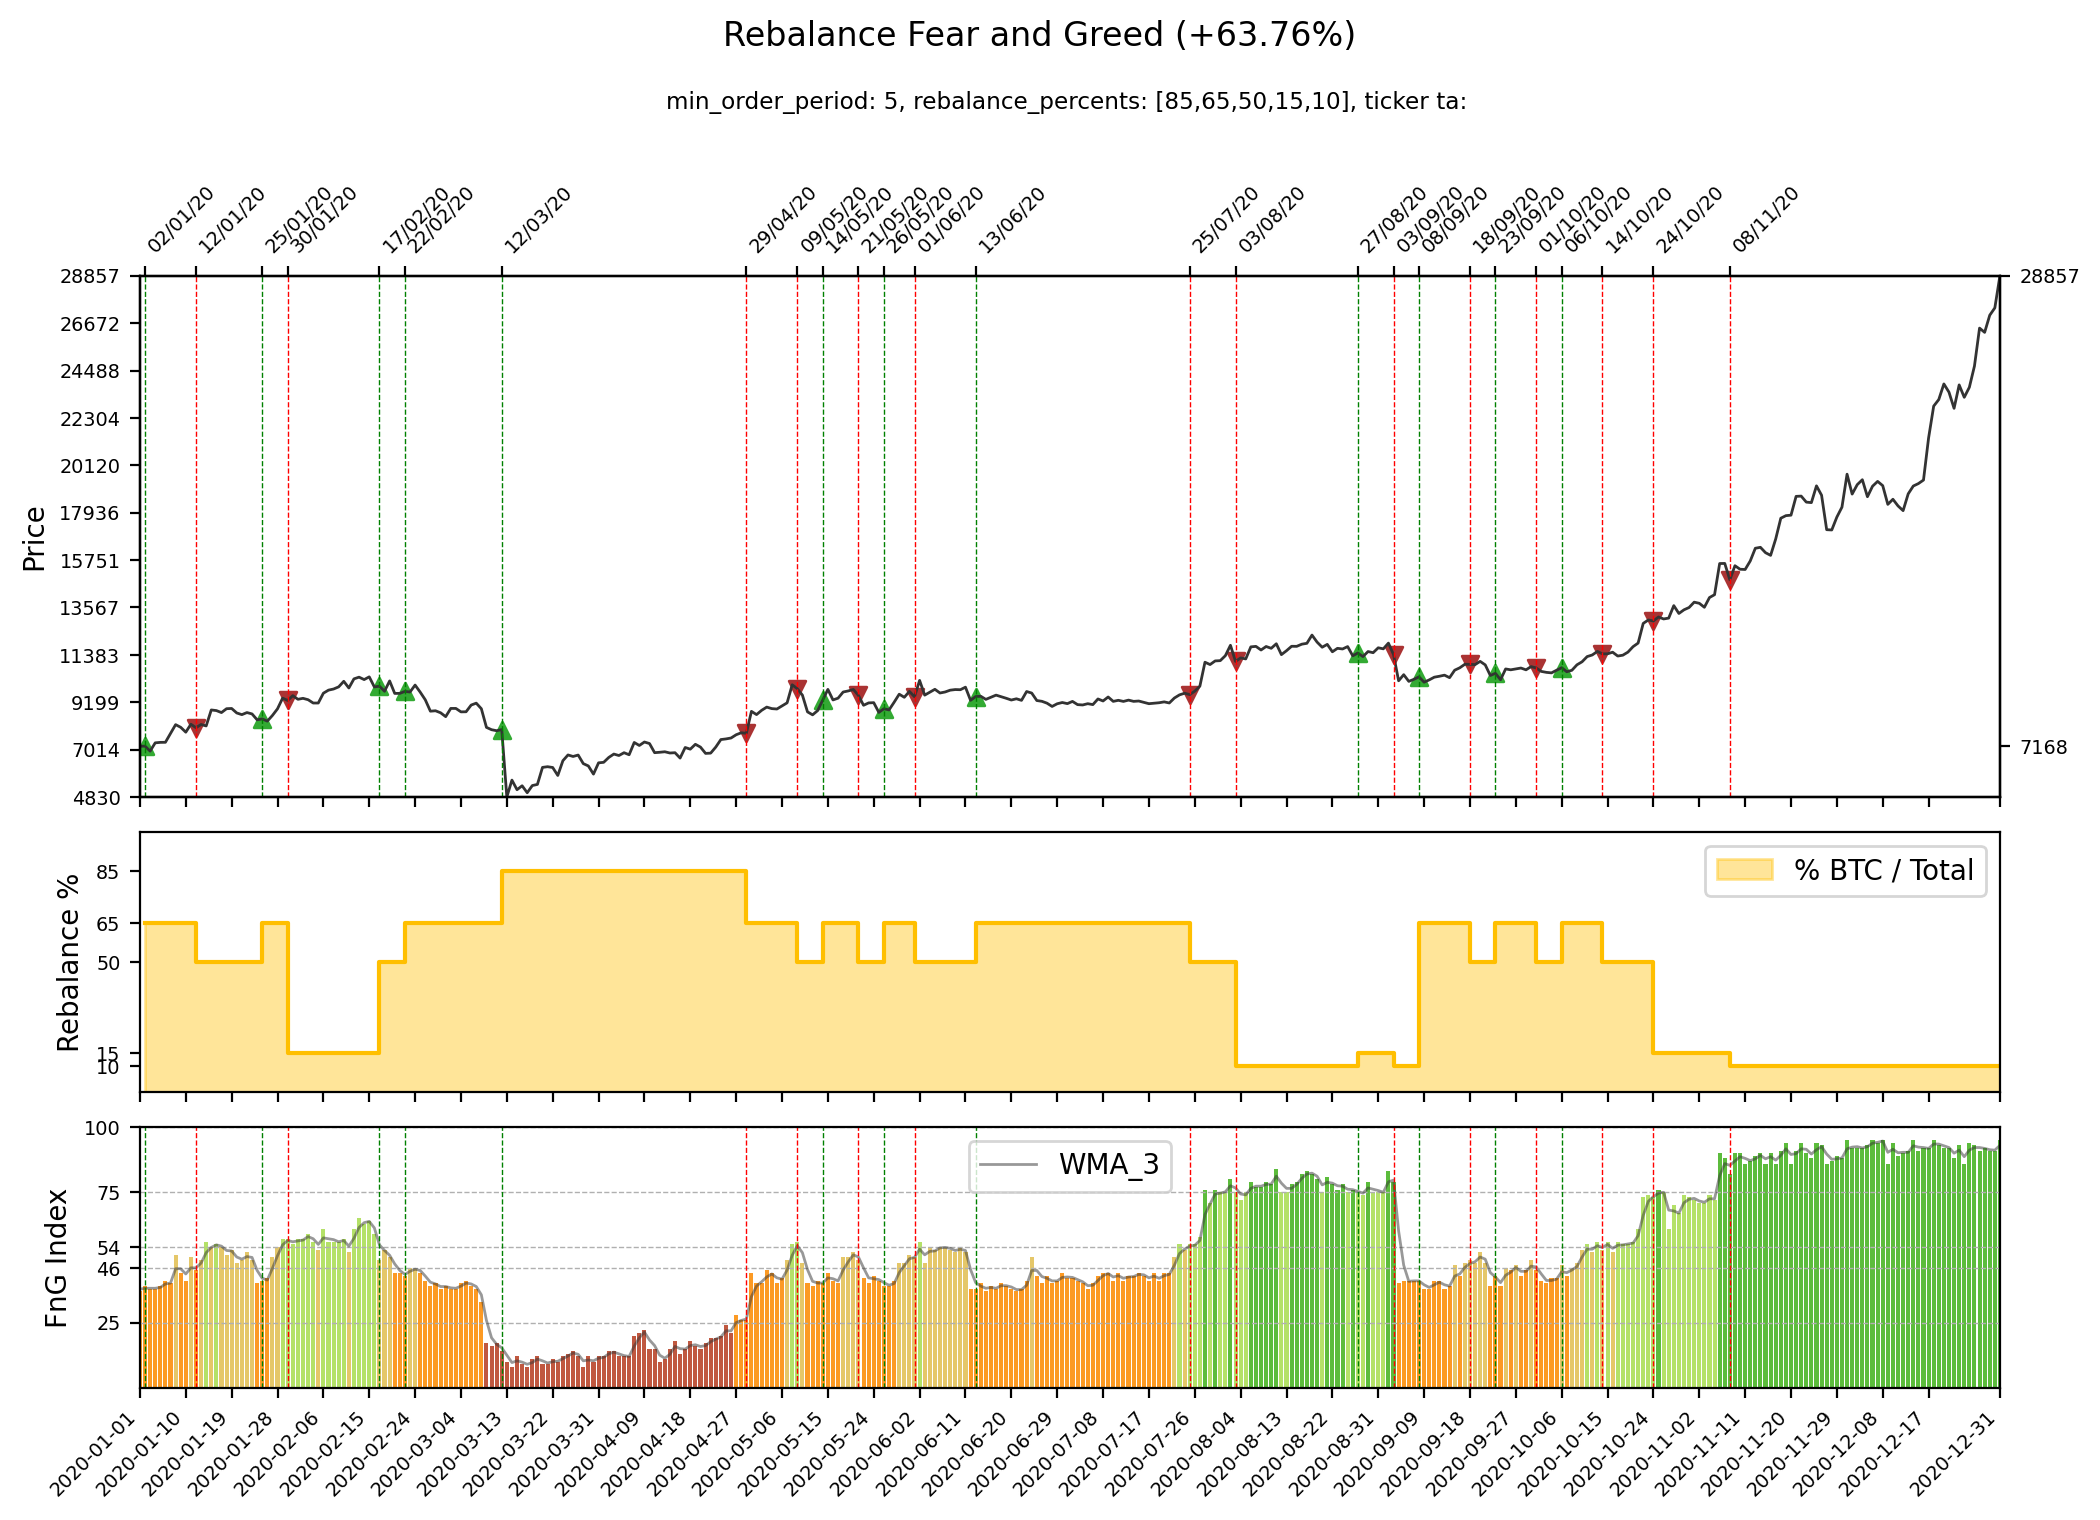

In [5]:
# %matplotlib widget      # Enable interactive plots

plot_results = True
plot_only_winner = False

if plot_results:
    for i in range(0, len(sorted_run_results)):
        sorted_run_results[i].plot(title_prefix='BEST: ' if i == 0 else '', title_suffix=f" ({sorted_run_results[i].pnl_percent:+.2f}%)")

        if plot_only_winner:
            break
